# 1. 라이브러리, 데이터 불러오기

In [ ]:
!python -m pip install pandas
!python -m pip install seaborn

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# CSV 불러오기
df = pd.read_csv("Bi-Annual_Pedestrian_Counts_20251028.csv")

# 한 번 확인
print(df.shape)
df.head()

(114, 113)


,the_geom,OBJECTID,Loc,Borough,Street_Nam,From_Stree,To_Street,Iex,May07_AM,May07_PM,...,Oct23_MD,June24_AM,June24_PM,June24_MD,Oct24_AM,Oct24_PM,Oct24_MD,May25_AM,May25_PM,May25_MD
0,POINT (-73.90459140730678 40.87919896648574),1,1,Bronx,Broadway,West 231st Street,Naples Terrace,N,"1,189","4,094",...,"1,745",901,"3,482","2,052","1,031","4,097",2229,811,"2,420","2,224"
1,POINT (-73.92188432870218 40.82662794123292),2,2,Bronx,East 161st Street,Gra Concourse,Sheridan Avenue,Y,"1,511","3,184",...,"1,287","2,113","4,155","1,493","3,016","4,685",1655,"2,928","4,168","2,468"
2,POINT (-73.89535781584335 40.86215460031517),3,3,Bronx,East Fordham Road,Valentine Avenue,Tiebout Avenue,Y,"1,832","12,311",...,"2,453","1,485","7,125","3,819","1,689","6,405",4417,"1,599","4,936","4,688"
3,POINT (-73.87892467324478 40.8812869959873),4,4,Bronx,East Gun Hill Road,Bainbridge Avenue,Rochambeau Avenue,N,764,"2,673",...,807,"1,394","2,023","1,190","1,495","2,474",1073,"1,261","1,779","1,133"
4,POINT (-73.88956389732787 40.844636776717664),5,5,Bronx,East Tremont Avenue,Prospect Avenue,Clinton Avenue,N,650,"2,538",...,"1,115",550,"1,455","1,563",725,"2,329",1888,714,"1,585","1,522"


# 2. 데이터 전처리

### 디버깅
* 22년도에 pM으로 네이밍되어있음 -> 대소문자 무시 로직 넣기

In [ ]:
import re

# 통행량 데이터 컬럼만 추출 (May/Sept + AM/MD/PM)
pattern = re.compile(r'^(May|Sept)\d{2}_(AM|PM|MD)$', re.IGNORECASE)
count_cols = [c for c in df.columns if pattern.match(c)]

# 위치 관련 컬럼
location_cols = ["Loc", "Borough", "Street_Nam", "From_Stree", "To_Street"]

# wide → long 변환
melted = df[location_cols + count_cols].melt(
    id_vars=location_cols,
    value_vars=count_cols,
    var_name="col",
    value_name="count"
)

# col 이름에서 기간 정보 추출
meta = melted["col"].str.extract(
    r'(?i)(?P<period>may|sept)(?P<year>\d{2})_(?P<part>am|md|pm)',  # (?i) = ignorecase 
    expand=True
)
melted = pd.concat([melted, meta], axis=1)

# ####디버깅 코드 : year에 NaN이 있는 행 확인#####
# meta.head()
# melted[melted["year"].isna()].head(20)

# 숫자 변환
melted["year"] = melted["year"].astype(int) + 2000
melted["count"] = pd.to_numeric(melted["count"], errors="coerce")

melted.head()


,Loc,Borough,Street_Nam,From_Stree,To_Street,col,count,period,year,part
0,1,Bronx,Broadway,West 231st Street,Naples Terrace,May07_AM,NaN,May,2007,AM
1,2,Bronx,East 161st Street,Gra Concourse,Sheridan Avenue,May07_AM,NaN,May,2007,AM
2,3,Bronx,East Fordham Road,Valentine Avenue,Tiebout Avenue,May07_AM,NaN,May,2007,AM
3,4,Bronx,East Gun Hill Road,Bainbridge Avenue,Rochambeau Avenue,May07_AM,764.0,May,2007,AM
4,5,Bronx,East Tremont Avenue,Prospect Avenue,Clinton Avenue,May07_AM,650.0,May,2007,AM


# 3. 지역별 총 통행량 계산 & 상위 지역 5개 확인

In [72]:
# Loc별 지역명 만들기 (짧게 표시)
df["지역명"] = df["Borough"] + " | " + df["Street_Nam"]

# melted에도 지역명 합치기
melted = melted.merge(df[["Loc", "지역명"]].drop_duplicates(), on="Loc", how="left")

# 위치별 전체 합계
by_loc = (
    melted.groupby(["Loc", "지역명"])["count"]
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)

# 상위 10개 지역
top5 = by_loc.head(5)
top5



,Loc,지역명,count
0,106,Harlem River Bridges | Broadway Bridge,48379.0
1,97,Staten Isla | New Dorp Lane,43585.0
2,76,Queens | Fresh Po Road,42951.0
3,100,Staten Isla | Victory Boulevard,42415.0
4,104,East River Bridges | Williamsburg Bridge,39752.0


# 4. 지도에서 시각화 하기
## 4.1. folium 지도
* 마커가 보이지 않음.

In [ ]:
!pip install folium geopy tqdm

In [ ]:
import folium
from geopy.geocoders import Nominatim
from tqdm import tqdm

# 상위 10개 지역만 사용 (top5 DataFrame)
geolocator = Nominatim(user_agent="pedestrian-map")

def get_latlon(row):
    try:
        location = geolocator.geocode(f"{row['Street_Nam']} and {row['To_Street']}, {row['Borough']}, New York")
        if location:
            return pd.Series([location.latitude, location.longitude])
    except:
        pass
    return pd.Series([None, None])

# tqdm으로 진행률 표시
tqdm.pandas()
top5[["lat", "lon"]] = top5.progress_apply(get_latlon, axis=1)

# 지도 중심은 뉴욕 중심부
m = folium.Map(location=[40.73, -73.94], zoom_start=11)

# 지도에 마커 추가
for _, row in top5.dropna(subset=["lat", "lon"]).iterrows():
    folium.CircleMarker(
        location=[row["lat"], row["lon"]],
        radius=12,                # 원 크기 키움
        color="black",            # 외곽선 색 진하게
        fill=True,
        fill_color="crimson",     # 채움색 진하게
        fill_opacity=0.8,         # 불투명하게
        popup=f"<b>{row['지역명']}</b><br>Count: {row['count']:,}"
    ).add_to(m)

m

## 4.2. 간단한 지도

In [73]:
import folium
from geopy.geocoders import Nominatim
import pandas as pd
import numpy as np

# ---  전체 기간 기준 총 보행량 합계 ---
total_by_loc = (
    melted.groupby("지역명")["count"]
    .sum()
    .reset_index()
    .sort_values("count", ascending=False)
)

# 상위 5개 지역 추출
top5_total_all = total_by_loc.head(5)
top5_total_all


# ---  좌표(위도, 경도) 얻기 ---
geolocator = Nominatim(user_agent="pedestrian-map")

def get_latlon(row):
    try:
        query = f"{row['지역명']}, New York City"
        location = geolocator.geocode(query, timeout=5)
        if location:
            return pd.Series([location.latitude, location.longitude])
    except:
        pass
    return pd.Series([None, None])

top5_total_all[["lat", "lon"]] = top5_total_all.apply(get_latlon, axis=1)


# ---  지도 생성 (심플한 스타일) ---
center = [40.73, -73.94]  # 뉴욕 중심 근처
m = folium.Map(location=center, zoom_start=12, tiles="CartoDB positron")

# --- 마커 표시 (보행량에 비례한 원 크기) ---
max_count = top5_total_all["count"].max()

for _, row in top5_total_all.dropna(subset=["lat", "lon"]).iterrows():
    size = (row["count"] / max_count) * 40  # 최대 40픽셀까지 원 크기 비례
    folium.CircleMarker(
        location=[row["lat"], row["lon"]],
        radius=size,
        color="crimson",
        fill=True,
        fill_color="crimson",
        fill_opacity=0.7,
        popup=f"<b>{row['지역명']}</b><br>총 보행자 수: {int(row['count']):,}"
    ).add_to(m)

m



C:\Users\mhi12\AppData\Local\Temp\ipykernel_19988\155373135.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top5_total_all[["lat", "lon"]] = top5_total_all.apply(get_latlon, axis=1)
C:\Users\mhi12\AppData\Local\Temp\ipykernel_19988\155373135.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top5_total_all[["lat", "lon"]] = top5_total_all.apply(get_latlon, axis=1)


# 5. 핫플레이스 증감 표로 시각화

### 5.1. 성장률 계산

In [ ]:
# 상위 10개 지역만 사용
hot_locs = top5["지역명"].tolist()

# 연도별 집계
by_year_loc = (
    melted[melted["지역명"].isin(hot_locs)]
    .groupby(["year", "지역명"])["count"]
    .sum()
    .reset_index()
)

# 전년 대비 성장률 계산 (%)
by_year_loc["growth_rate"] = by_year_loc.groupby("지역명")["count"].pct_change() * 100

by_year_loc.head()


,year,지역명,count,growth_rate
0,2007,East River Bridges | Williamsburg Bridge,1607.0,NaN
1,2007,Harlem River Bridges | Broadway Bridge,2962.0,NaN
2,2007,Queens | Fresh Po Road,4141.0,NaN
3,2007,Staten Isla | New Dorp Lane,2011.0,NaN
4,2007,Staten Isla | Victory Boulevard,2429.0,NaN


### 5.2. 표로 시각화

* 문제점 : 결측치 존재
* 특이점 : 보행량 감소

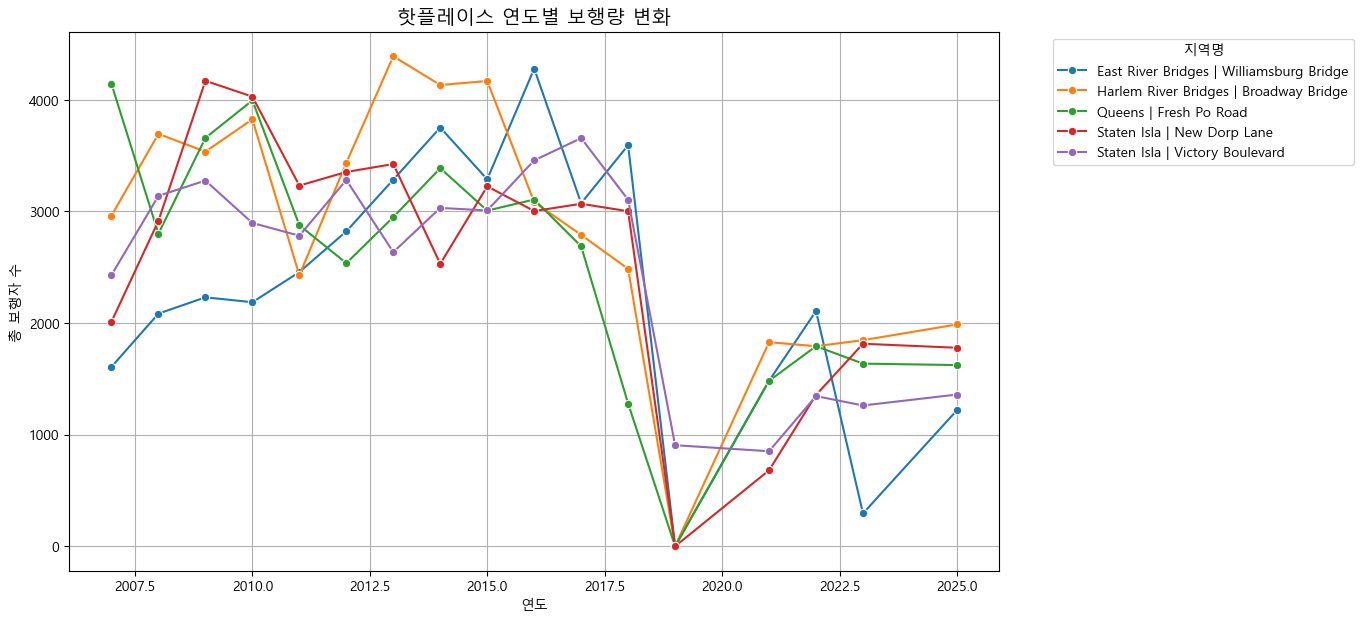

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib.font_manager as fm

plt.rcParams['font.family'] = 'Malgun Gothic'  # 한글 폰트 설정 (윈도우용)

plt.figure(figsize=(12,7))
sns.lineplot(data=by_year_loc, x="year", y="count", hue="지역명", marker="o")
plt.title("핫플레이스 연도별 보행량 변화", fontsize=14)
plt.xlabel("연도")
plt.ylabel("총 보행자 수")
plt.grid(True)
plt.legend(title="지역명", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()


# 6. 성장률을 기준으로

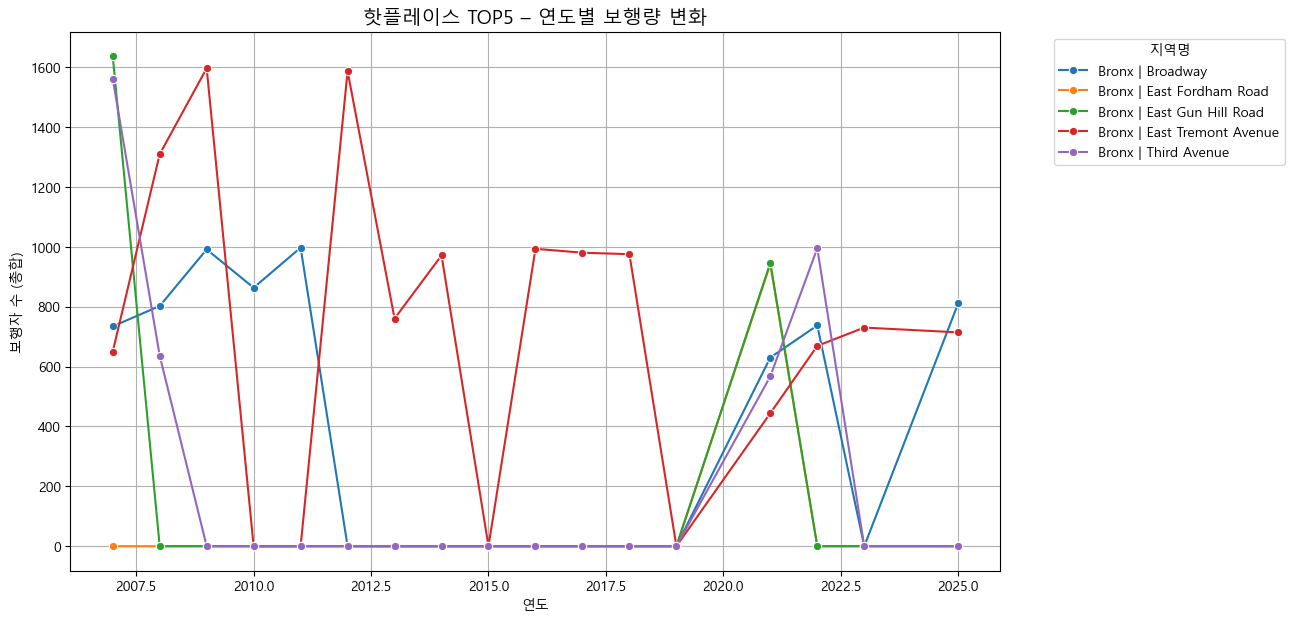

In [ ]:
# 연도별 지역별 보행량 합계
by_year_loc = (
    melted.groupby(["year", "지역명"])["count"]
    .sum()
    .reset_index()
)

# 전년 대비 성장률(%) 계산
by_year_loc["growth_rate"] = by_year_loc.groupby("지역명")["count"].pct_change() * 100



# 지역별 평균 성장률 계산 (NaN은 기본적으로 자동 무시됨) ###################
avg_growth = (
    by_year_loc.groupby("지역명")["growth_rate"]
    .mean()  # skipna 인자 제거
    .reset_index()
    .sort_values("growth_rate", ascending=False)
)

# 성장률 상위 5개 핫플레이스
top5_growth = avg_growth.head(5)
top5_growth



# 그래프 #########################
import matplotlib.pyplot as plt
import seaborn as sns

top5_names = top5_growth["지역명"].tolist()

plt.figure(figsize=(12,7))
sns.lineplot(
    data=by_year_loc[by_year_loc["지역명"].isin(top5_names)],
    x="year", y="count", hue="지역명", marker="o"
)
plt.title("핫플레이스 TOP5 – 연도별 보행량 변화", fontsize=14)
plt.xlabel("연도")
plt.ylabel("보행자 수 (총합)")
plt.grid(True)
plt.legend(title="지역명", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()



# 7. 큰 거리 5개 비교

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Malgun Gothic'  # 한글 폰트
plt.rcParams['axes.unicode_minus'] = False

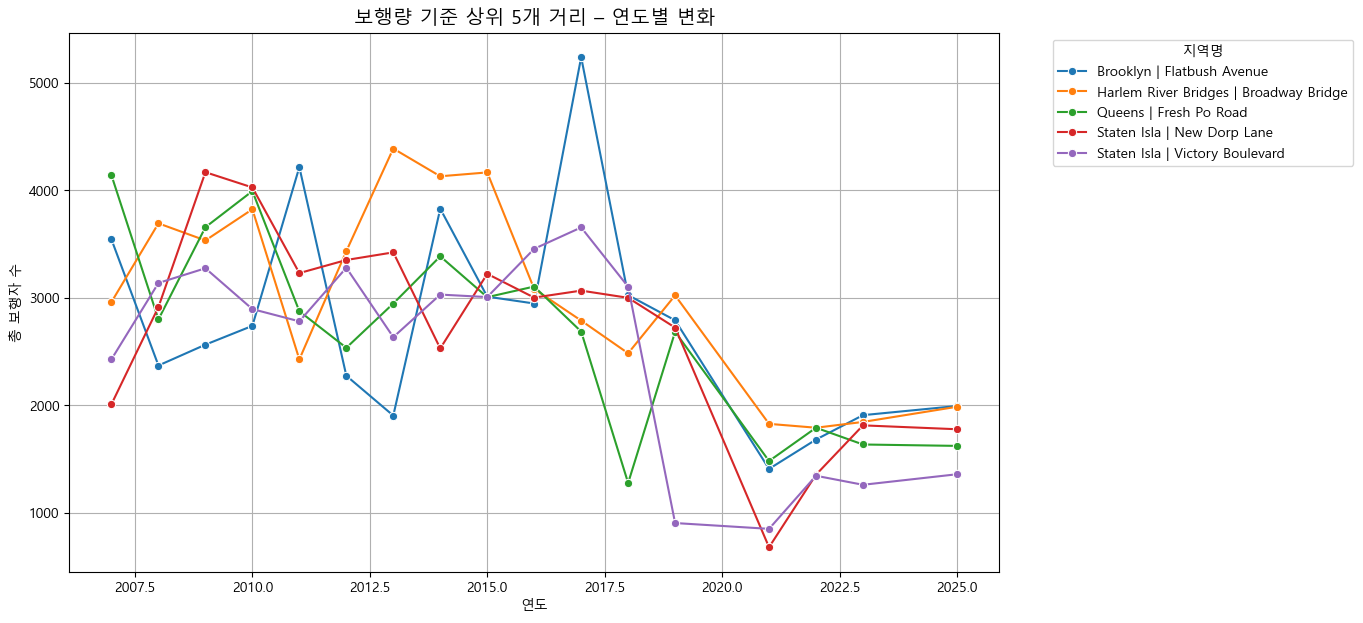

In [57]:
# 연도별, 지역별 총 보행량 합계
by_year_loc = (
    melted.groupby(["year", "지역명"])["count"]
    .sum()
    .reset_index()
)


# 각 지역의 전체 보행량 합계
total_counts = (
    by_year_loc.groupby("지역명")["count"]
    .sum()
    .reset_index()
    .sort_values("count", ascending=False)
)

# 총 보행량 기준 상위 5개
top5_total = total_counts.head(5)
top5_total

# 상위 5개 거리 이름 추출
top5_names = top5_total["지역명"].tolist()

# 이들만 필터링
filtered = by_year_loc[by_year_loc["지역명"].isin(top5_names)].copy()

# 결측치(보행량) 평균으로 채우기
filtered["count"] = filtered["count"].replace(0, np.nan)
filtered["count"] = filtered.groupby("지역명")["count"].transform(
    lambda x: x.fillna(x.mean())
)

plt.figure(figsize=(12,7))
sns.lineplot(data=filtered, x="year", y="count", hue="지역명", marker="o")
plt.title("보행량 기준 상위 5개 거리 – 연도별 변화", fontsize=14)
plt.xlabel("연도")
plt.ylabel("총 보행자 수")
plt.grid(True)
plt.legend(title="지역명", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()



# 최근 3개년

최근 3개년: [2023, 2024, 2025], 데이터 행 수: 684
최근 3년간 총 보행량 상위 5개 지역:


,지역명,count
81,Queens | Jamaica Avenue,14565.0
18,Brooklyn | Flatbush Avenue,11709.0
59,Manhattan | Madison Avenue,9600.0
8,Brooklyn | 5th Avenue,9292.0
88,Queens | Queens Boulevard,6741.0


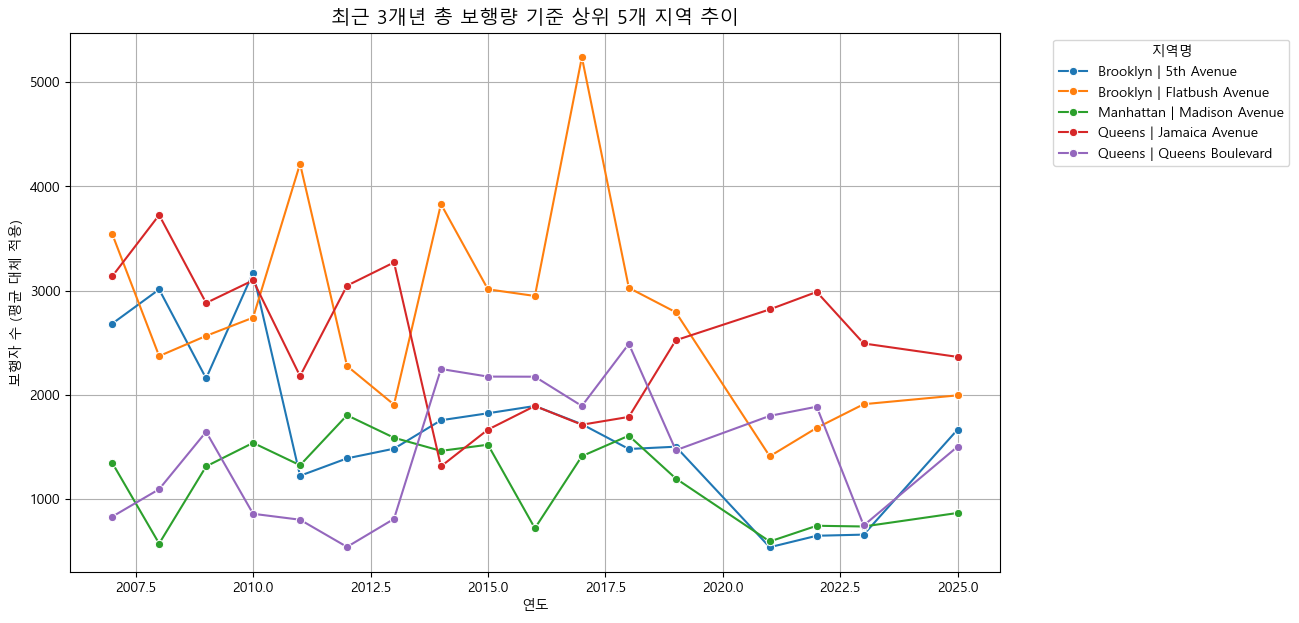

C:\Users\mhi12\AppData\Local\Temp\ipykernel_19988\1361512204.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top5_recent, x="count", y="지역명", palette="YlOrRd")


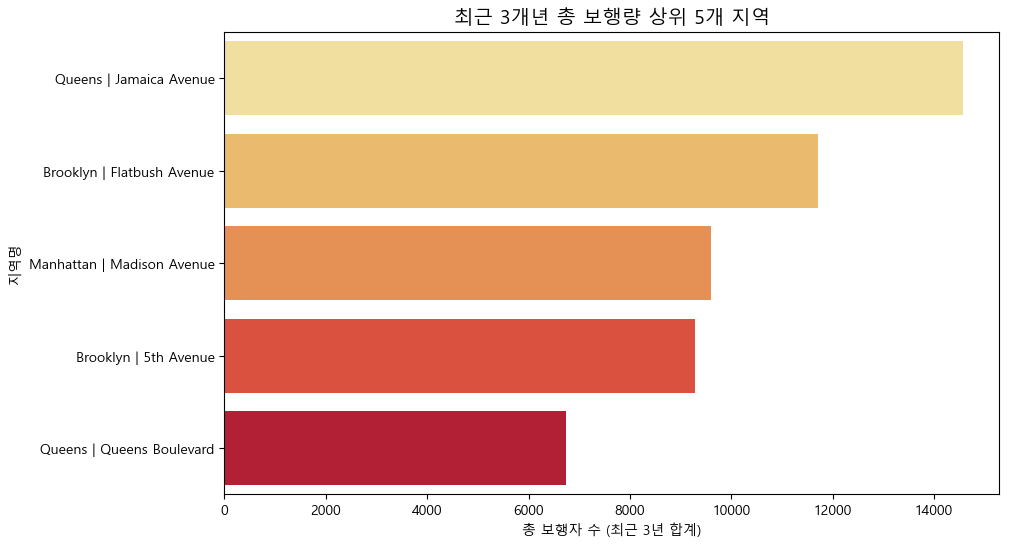

In [63]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# --- 1️⃣ 최근 3개년 데이터 선택 ---
melted["year"] = pd.to_numeric(melted["year"], errors="coerce")
latest_year = int(melted["year"].dropna().max())
recent_years = [latest_year - 2, latest_year - 1, latest_year]

recent = melted[melted["year"].isin(recent_years)].copy()
print(f"최근 3개년: {recent_years}, 데이터 행 수: {len(recent)}")

# --- 2️⃣ 0 및 NaN을 평균으로 대체 ---
recent["count"] = recent["count"].replace(0, np.nan)
recent["count"] = recent.groupby("지역명")["count"].transform(lambda x: x.fillna(x.mean()))

# --- 3️⃣ 최근 3개년 총 보행량 기준 상위 5개 지역 ---
top5_recent = (
    recent.groupby("지역명")["count"]
    .sum()
    .reset_index()
    .sort_values("count", ascending=False)
    .head(5)
)
top5_names = top5_recent["지역명"].tolist()

print("최근 3년간 총 보행량 상위 5개 지역:")
display(top5_recent)

# --- 4️⃣ 상위 5개 지역의 연도별 보행량 추이 ---
trend_top5 = (
    melted[melted["지역명"].isin(top5_names)]
    .groupby(["year", "지역명"])["count"]
    .sum()
    .reset_index()
)

# 결측치 및 0값을 각 지역 평균으로 대체
trend_top5["count"] = trend_top5["count"].replace(0, np.nan)
trend_top5["count"] = trend_top5.groupby("지역명")["count"].transform(lambda x: x.fillna(x.mean()))

# --- 5️⃣ 시각화 ---
plt.figure(figsize=(12,7))
sns.lineplot(data=trend_top5, x="year", y="count", hue="지역명", marker="o")
plt.title("최근 3개년 총 보행량 기준 상위 5개 지역 추이", fontsize=14)
plt.xlabel("연도")
plt.ylabel("보행자 수 (평균 대체 적용)")
plt.grid(True)
plt.legend(title="지역명", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

# --- 6️⃣ 보행량 총합 비교 (바 차트) ---
plt.figure(figsize=(10,6))
sns.barplot(data=top5_recent, x="count", y="지역명", palette="YlOrRd")
plt.title("최근 3개년 총 보행량 상위 5개 지역", fontsize=14)
plt.xlabel("총 보행자 수 (최근 3년 합계)")
plt.ylabel("지역명")
plt.show()


In [66]:
import folium
from geopy.geocoders import Nominatim

# 지도 중심 (뉴욕 시청 근처)
center = [40.7128, -74.0060]

# 최소한의 배경 (tiles='CartoDB positron' or 'Stamen Toner Lite')
m = folium.Map(location=center, zoom_start=12, tiles="CartoDB positron")

# --- 지오코딩 함수 (도로명 기준 좌표 추정) ---
geolocator = Nominatim(user_agent="simple-ped-map")

def get_latlon(row):
    try:
        query = f"{row['지역명']}, New York City"
        location = geolocator.geocode(query, timeout=5)
        if location:
            return pd.Series([location.latitude, location.longitude])
    except:
        pass
    return pd.Series([None, None])

# top5_recent에 lat/lon 추가 (이미 있으면 생략 가능)
if "lat" not in top5_recent.columns:
    top5_recent[["lat", "lon"]] = top5_recent.apply(get_latlon, axis=1)

# --- 지도에 단순한 원형 마커 표시 ---
for _, row in top5_recent.dropna(subset=["lat", "lon"]).iterrows():
    folium.CircleMarker(
        location=[row["lat"], row["lon"]],
        radius=12,
        color="crimson",
        fill=True,
        fill_color="crimson",
        fill_opacity=0.7,
        popup=f"<b>{row['지역명']}</b><br>보행자 수: {int(row['count']):,}"
    ).add_to(m)

# 결과 지도 출력
m


# 데이터 셋

- https://data.cityofnewyork.us/Transportation/Bi-Annual-Pedestrian-Counts/2de2-6x2h
- 위치정보
- 매년(07~25) + 월(2회: 5월, 9월) + 시간대 통행량(3회: AM, MD, PM)

# 분석 로직

- 지역 통행량 순서
- 그중 가장 높은 지역
- 가장 높은 지역 3개의 성장/ 감소 추이

# 결과

1. 전체 보행량 기준 TOP5는 최근 5개년동안 이동량이 줄었다.
2. 2019년때 전반적인 결측치가 있다
3. 단순히 상승률을 기준한 TOP5는 의미가 없다.
4. 최근 3개년 기준 TOP5는 통행량이 비교적 균등하고 상승한 지역도 있다.

# 문제점

직접 몇개의 데이터를 검증해본결과 결과에 이상을 확인

- count가 10000~20000 에 달하는 Manhattan Eighth Avenue에 경우 TOP5에 없음.

# 문제 해결

XX

# 추가 아이디어.

임대로에 따른 유동인구의 차이가 궁금함 

우리나라에선 [특색있는 곳이 핫플로 인식 → 임대로 상승 → 프렌차이즈 입성 → 특수성을 잃음 → 이동인구 감소] ex) 홍대, 가로수길 이렇게 이어지는 경우가 많은데 외국도 비슷할지?